# M06. Base Running
- This predicts errors, double plays, out locations, and baserunner advancements
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Created: 12/16/2023
- Updated: 2/5/2025

## Imports

In [92]:
%run "U01. Imports.ipynb"
%run "U02. Functions.ipynb"
%run "U03. Classes.ipynb"
%run "U04. Datasets.ipynb"

In [93]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Data

##### Steamer

In [94]:
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')

##### MLB Stats API

Notes: 
- This cannot use the same complete dataset as elsewhere because multiple records per plate appearance are required and those are typically dropped
- MLB Stats API calls are highly prone to connection errors. Because of this, it's highly discouraged to run them all in parallel or in one large call. Sadly, the below approach is the best I've got.

Create yearly dataframes

In [95]:
# df2015 = plays_statsapi("04/01/2015", "10/31/2015")
# df2016 = plays_statsapi("04/01/2016", "10/31/2016")
# df2017 = plays_statsapi("04/01/2017", "10/31/2017")
# df2018 = plays_statsapi("04/01/2018", "10/31/2018")
# df2019 = plays_statsapi("04/01/2019", "10/31/2019")
# df2020 = plays_statsapi("04/01/2020", "10/31/2020")
# df2021 = plays_statsapi("04/01/2021", "10/31/2021")
# df2022 = plays_statsapi("04/01/2022", "10/31/2022")
# df2023 = plays_statsapi("04/01/2023", "10/31/2023")
# df2024 = plays_statsapi("04/01/2024", "10/31/2024")
# df2025 = plays_statsapi("04/01/2025", "11/01/2025")

Concatenate yearly dataframes

In [96]:
# running_dataset = pd.concat([df2015, df2016, df2017, df2018, df2019, df2020, df2021, df2022, df2023, df2024, df2025], axis=0).query('game_type == "R"')

Write to CSV

In [97]:
# running_dataset.to_csv(os.path.join(baseball_path, "Running Dataset.csv"), index=False)

Read CSV

In [98]:
running_dataset = pd.read_csv(os.path.join(baseball_path, "Running Dataset.csv"))

### Clean

##### Steamer

Create derived statistics and drop records with missing data

In [99]:
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df).dropna(subset=batter_stats_fg)

Calculate imputed stolen base attempt and success rates

In [100]:
steamer_hitters_df2['sba_imp'] = steamer_hitters_df2['sba'] / steamer_hitters_df2['sbo']
steamer_hitters_df2['sb_imp'] = steamer_hitters_df2['sb'] / steamer_hitters_df2['sba']

Format data types for merge

In [101]:
steamer_hitters_df2['date'] = steamer_hitters_df2['date'].astype(int)
steamer_hitters_df2['mlbamid'] = steamer_hitters_df2['mlbamid'].astype(int)
steamer_hitters_df2['date'] = pd.to_datetime(steamer_hitters_df2['date'], format='%Y%m%d')

##### MLB Stats API

There are two major issues with the MLB Stats API data that require correcting before use in training models:
1. Base runners that move multiple bases during a plate appearance will not have their full movement recorded within a single observation and may be treated as duplicates
2. Base runners that do not move during a plate appearance will not have their own observation in the data <br>

Since the model requires knowing where base runners/batters start and end with each plate appearance, we need to address these problems.

##### Problem 1. Multiple Movements

Identify where a runner starts and ends in an at bat. Only keep one instance. <br>
Note: This step needs to be done first to avoid creating duplicate observations.

##### Determine start and end bases

Assumption: runner on base after the previous PA is the runner on base at the start of the next PA

Extract id for base runners after the PA

In [102]:
running_dataset['postOnFirst'] = running_dataset['postOnFirst'].str.extract(r"'id': (\d+)")
running_dataset['postOnSecond'] = running_dataset['postOnSecond'].str.extract(r"'id': (\d+)")
running_dataset['postOnThird'] = running_dataset['postOnThird'].str.extract(r"'id': (\d+)")

Shift by one to apply the plate appearances end state onto the next observation's start state

In [103]:
running_dataset['preOnFirst'] = (running_dataset.groupby(['gamePk', 'inning', 'halfInning'])['postOnFirst'].shift(1))
running_dataset['preOnSecond'] = (running_dataset.groupby(['gamePk', 'inning', 'halfInning'])['postOnSecond'].shift(1))
running_dataset['preOnThird'] = (running_dataset.groupby(['gamePk', 'inning', 'halfInning'])['postOnThird'].shift(1))

Fill missings with "Empty" - this allows for the subsequent transform('first') column to accept missings as a first value

In [104]:
running_dataset[['preOnFirst', 'preOnSecond', 'preOnThird']] = running_dataset[['preOnFirst', 'preOnSecond', 'preOnThird']].fillna("Empty")

Assign the first observation's base start state's to the entire PA

In [105]:
running_dataset[['preOnFirst', 'preOnSecond', 'preOnThird']] = (running_dataset.groupby(['gamePk', 'inning', 'halfInning', 'atBatIndex'])[['preOnFirst', 'preOnSecond', 'preOnThird']].transform('first'))

Determine start and end base by number:
- 0. AB
- 1. 1B
- 2. 2B
- 3. 3B
- 4. Scored
- 5. Out

In [106]:
running_dataset['startInt'] = running_dataset['start'].apply(lambda x: 0 if pd.isna(x) else int(x[0]) if x[0].isdigit() else 0)
running_dataset['endInt'] = running_dataset['end'].apply(lambda x: 5 if pd.isna(x) else 4 if x.lower() == 'score' else int(x[0]) if x[0].isdigit() else 0)

In [107]:
running_dataset['minBase'] = running_dataset.groupby(['gamePk', 'atBatIndex', 'runner_id'])['startInt'].transform('min')
running_dataset['maxBase'] = running_dataset.groupby(['gamePk', 'atBatIndex', 'runner_id'])['endInt'].transform('max')

Notes:
- At this state, we have the start (minBase) and end (maxBase) locations for all batters/base runners **who moved** (inclusive of batters who got out in any fashion).
- If a base runner moved for multiple reasons (let's say from first to second on a single and second to third on an error), they may appear in the dataset multiple times.

Warning: minBase and maxBase are used to determine how PA events affect base runners. However, they can also change via stolen base. If this is not accounted for, there may exist higher than expected advance probabilities. For example, a runner stealing second and then scoring on a single would have a minBase of 1 and a maxBase of 4, but attributing three bases of movement to the single would be unwise. This can be addressed in two possible ways:
1. Adjusting minBase and maxBase to account for the states right before the deciding pitch, not at the start of the PA
2. Removing such PAs from the sample. There's little downside to this as samples are large enough after removing PAs with SBs, so let's do this for now! PAs with stolen base attempts and other non-typical advances will be excluded using the movementTypical variable.

Identify plate appearances with only typical movement (to be included in base running models)

Movement Reasons:
- r_adv_force: advanced on a ball in play because they were forced to
- r_adv_play: advanced on a ball in play without being forced to
- r_force_out: out on a force play
- r_adv_throw: advanced on the throw, not the contact
- r_runner_out: out not on a force play
- r_thrown_out: out on a hit (base runner)
- r_doubled_off: out on a ball caught and thrown to base
- r_out_stretching: out on a hit (hitter)

In [108]:
movementReason_list = ['r_adv_force', 'r_adv_play', 'r_force_out', 'r_adv_throw', 'r_runner_out', 'r_thrown_out', 'r_doubled_off', 'r_out_stretching']

running_dataset['movementTypical'] = running_dataset['movementReason'].apply(lambda x: 1 if x in movementReason_list or pd.isna(x) else 0)
running_dataset['movementTypical'] = running_dataset.groupby(['gamePk', 'atBatIndex'])['movementTypical'].transform('min')

Stolen Bases and Attempts

In [109]:
running_dataset['sb_2b'] = running_dataset['movementReason'].isin(['r_stolen_base_2b']).astype('int') 
running_dataset['sb_3b'] = running_dataset['movementReason'].isin(['r_stolen_base_3b']).astype('int') 
running_dataset['sba_2b'] = running_dataset['movementReason'].isin(['r_stolen_base_2b', 'r_caught_stealing_2b', 'r_pickoff_caught_stealing_2b']).astype('int') 
running_dataset['sba_3b'] = running_dataset['movementReason'].isin(['r_stolen_base_3b', 'r_caught_stealing_3b', 'r_pickoff_caught_stealing_3b']).astype('int') 

In [110]:
running_dataset[['sb_2b', 'sb_3b', 'sba_2b', 'sba_3b']] = running_dataset.groupby(['gamePk', 'atBatIndex', 'runner_id'])[['sb_2b', 'sb_3b', 'sba_2b', 'sba_3b']].transform('max')

Now that movementTypical and stolen base fields are applied to entire PAs and runners, respectively, we have everything we need for base runners on each observation, allowing us to drop duplicates

In [111]:
running_dataset.drop_duplicates(subset=['gamePk', 'atBatIndex', 'runner_id', 'startInt'], inplace=True, keep='first')

##### Problem 2. Missing Base Runners

##### At Bat

There will always be an observation for the guy at bat unless a base runner ended the inning with an out. We don't need those observations anyway.

In [112]:
atBat = running_dataset.query('id == batter')

atBat.drop_duplicates(['gamePk', 'atBatIndex', 'runner_id'], keep='first', inplace=True)

##### Runners on 1B

Runner will either have an observation if they moved or one will be created by modifying the batter or another base runner's observation

In [113]:
# Identify all observations with runners on specified base
on1B = running_dataset[running_dataset['preOnFirst'] != "Empty"]

# Identify observations where we have the base runner as their own observation
on1B['is_runner'] = (on1B['preOnFirst'].astype(str) == on1B['runner_id'].astype(str)).astype(int)

# Sort to bring those observations to the top of their PA, where possible
on1B = on1B.sort_values(by=['gamePk', 'atBatIndex', 'is_runner', 'startInt'], ascending=[True, True, False, True])

# Drop duplicates, keeping one record per PA, preferring the actual base runner, where possible
on1B.drop_duplicates(subset=['gamePk', 'atBatIndex'], keep='first', inplace=True)

# Overwrite base runners to make them valid versions of the runner on base
on1B.loc[on1B['start'] != "1B", ['startInt', 'endInt', 'minBase', 'maxBase']] = 1
on1B.loc[on1B['start'] != "1B", ['start', 'end']] = "1B"
on1B.loc[on1B['start'] != "1B", ['id', 'runner_id']] = on1B.loc[on1B['start'] != "1B", 'preOnFirst'].rename("id").to_frame().assign(runner_id=lambda df: df['id'])

##### Runners on 2B

In [114]:
# Identify all observations with runners on specified base
on2B = running_dataset[running_dataset['preOnSecond'] != "Empty"]

# Identify observations where we have the base runner as their own observation
on2B['is_runner'] = (on2B['preOnSecond'].astype(str) == on2B['runner_id'].astype(str)).astype(int)

# Sort to bring those observations to the top of their PA, where possible
on2B = on2B.sort_values(by=['gamePk', 'atBatIndex', 'is_runner', 'startInt'], ascending=[True, True, False, True])

# Drop duplicates, keeping one record per PA, preferring the actual base runner, where possible
on2B.drop_duplicates(subset=['gamePk', 'atBatIndex'], keep='first', inplace=True)

# Overwrite base runners to make them valid versions of the runner on base
on2B.loc[on2B['start'] != "2B", ['startInt', 'endInt', 'minBase', 'maxBase']] = 2
on2B.loc[on2B['start'] != "2B", ['start', 'end']] = "2B"
on2B.loc[on2B['start'] != "2B", ['id', 'runner_id']] = on2B.loc[on2B['start'] != "2B", 'preOnSecond'].rename("id").to_frame().assign(runner_id=lambda df: df['id'])

##### Runners on 3B

In [115]:
# Identify all observations with runners on specified base
on3B = running_dataset[running_dataset['preOnThird'] != "Empty"]

# Identify observations where we have the base runner as their own observation
on3B['is_runner'] = (on3B['preOnThird'].astype(str) == on3B['runner_id'].astype(str)).astype(int)

# Sort to bring those observations to the top of their PA, where possible
on3B = on3B.sort_values(by=['gamePk', 'atBatIndex', 'is_runner', 'startInt'], ascending=[True, True, False, True])

# Drop duplicates, keeping one record per PA, preferring the actual base runner, where possible
on3B.drop_duplicates(subset=['gamePk', 'atBatIndex'], keep='first', inplace=True)

# Overwrite base runners to make them valid versions of the runner on base
on3B.loc[on3B['start'] != "3B", ['startInt', 'endInt', 'minBase', 'maxBase']] = 3
on3B.loc[on3B['start'] != "3B", ['start', 'end']] = "3B"
on3B.loc[on3B['start'] != "3B", ['id', 'runner_id']] = on3B.loc[on3B['start'] != "3B", 'preOnThird'].rename("id").to_frame().assign(runner_id=lambda df: df['id'])

##### Combine

In [116]:
df = pd.concat([atBat, on1B, on2B, on3B], axis=0, ignore_index=True)

Sort to group PAs together

In [117]:
df['atBatIndexNum'] = df.groupby(['gamePk', 'atBatIndex']).cumcount() + 1
df.sort_values(['gamePk', 'atBatIndex', 'atBatIndexNum'], inplace=True)

##### Base Dummies

Start Locations

In [118]:
df['pre_1b'] = (df['preOnFirst'] != "Empty").astype('int')
df['pre_2b'] = (df['preOnSecond'] != "Empty").astype('int')
df['pre_3b'] = (df['preOnThird'] != "Empty").astype('int')

End Locations

In [119]:
df['post_1b'] = pd.notna(df['postOnFirst']).astype('int')
df['post_2b'] = pd.notna(df['postOnSecond']).astype('int')
df['post_3b'] = pd.notna(df['postOnThird']).astype('int')

Blocked Bases (bases a given base runner could not advance to because there's a runner **ahead** of them)

In [120]:
df['blocked_1b'] = ((df['post_1b'] == 1) & (df['maxBase'] < 1)).astype('int')
df['blocked_2b'] = ((df['post_2b'] == 1) & (df['maxBase'] < 2)).astype('int')
df['blocked_3b'] = ((df['post_3b'] == 1) & (df['maxBase'] < 3)).astype('int')

##### Events

In [121]:
df = create_events(df)
df['eventsModelInt'] = df['eventsModel'].map({'b1': 1, 'b2': 2, 'b3': 3, 'hr': 4, 'bb': 5, 'hbp': 6, 'so': 7, 'fo': 8, 'go': 9, 'lo': 10, 'po': 11})

Create dummies

In [122]:
event_dummies = pd.get_dummies(df[df['eventsModel'] != "Cut"]['eventsModel'], prefix='event').astype(int)
minBase_dummies = pd.get_dummies(df['minBase'], prefix='minBase').astype(int)

df = pd.concat([df, event_dummies, minBase_dummies], axis=1)

##### Out Locations

Runner is out dummy

In [123]:
df['out'] = (df['maxBase'] == 5).astype('int')

Base out dummies

In [124]:
df['out_home'] = ((df['out'] == 1) & (df['minBase'] == 0)).astype('int')
df['out_1b'] = ((df['out'] == 1) & (df['minBase'] == 1)).astype('int')
df['out_2b'] = ((df['out'] == 1) & (df['minBase'] == 2)).astype('int')
df['out_3b'] = ((df['out'] == 1) & (df['minBase'] == 3)).astype('int')

df['out_home'] = df.groupby(['gamePk', 'atBatIndex'])['out_home'].transform('max')
df['out_1b'] = df.groupby(['gamePk', 'atBatIndex'])['out_1b'].transform('max')
df['out_2b'] = df.groupby(['gamePk', 'atBatIndex'])['out_2b'].transform('max')
df['out_3b'] = df.groupby(['gamePk', 'atBatIndex'])['out_3b'].transform('max')

##### Outs in Inning

Calculate number of outs on play

In [125]:
df['outs_calculated'] = df.groupby(['gamePk', 'atBatIndex'])['out'].transform('sum')

Calculate number of outs prior to PA

In [126]:
df['outs_pre'] = df.groupby(['gamePk', 'inning', 'halfInning'])['outs'].shift(1)
df['outs_pre'] = df.groupby(['gamePk', 'atBatIndex'])['outs_pre'].transform('min')
df['outs_pre'] = np.where(df['outs_pre'] == 3, 0, df['outs_pre'])

df['outs_pre'].fillna(0, inplace=True)

##### Errors

In [127]:
df['error'] = df['description'].fillna("Missing").str.contains('error', case=False).astype('int')
df['error'] = np.where((df['outs_calculated'] == 0) & (df['eventType'] == 'fielders_choice'), 1, df['error'])

##### Double Plays

In [128]:
df['double_play'] = df['eventType'].isin(['grounded_into_double_play', 'double_play', 'sac_fly_double_play', 'strikeout_double_play', 'sac_bunt_double_play']).astype(int)
df['double_play'] = np.where(df['outs_calculated'] == 2, 1, df['double_play'])

##### Descriptive

Determine year

In [129]:
df['year'] = df["game_date"].astype('str').str[:4].astype('int')

Format data types for merge

In [130]:
df['date'] = df['game_date'].str.replace("-", "").astype(int)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

df['runner_id'] = df['runner_id'].astype(int)

### Merge

In [131]:
df = pd.merge_asof(
    df.sort_values('date'),  
    steamer_hitters_df2[['mlbamid', 'date', 'sb', 'sbo', 'sba', 'sb_imp', 'sba_imp']].sort_values('date'),
    left_on='date',
    right_on='date',
    left_by='runner_id',
    right_by='mlbamid'
)

Resort in more logical order

In [132]:
df.sort_values(['gamePk', 'atBatIndex'], inplace=True)

### Sample

Drop triple plays

In [133]:
df = df.query('outs_calculated != 3')

Drop recent data (recent Steamer data is not available)

In [134]:
df = df[df['year'] < 2025]

### Model A. Errors

##### Inputs

In [135]:
error_input_list = list(event_dummies.columns) + ['pre_1b', 'pre_2b', 'pre_3b']

Note: removed outs_pre because of small sample sizes with specific combinations could lead to high error rates

##### Sample

Universe: Typical events. Typical base movement. Using the batter as the observation.

In [136]:
X = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('startInt == 0')[error_input_list]
y = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('startInt == 0')['error']

##### Train/Test Split

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

##### Settings

In [138]:
random_state = 10

##### Train

In [139]:
%%time
models = [
    MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=10, random_state=random_state+1),
    # MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=10, random_state=random_state+2),
    # MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', max_iter=10, random_state=random_state+3)
    ]

# Create the ensemble classifier using VotingClassifier
predict_errors = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Create directory
os.makedirs(os.path.join(model_path, "M06. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_errors, open(os.path.join(model_path, "M06. Base Running", todaysdate, "predict_errors.sav"), 'wb'))

CPU times: total: 500 ms
Wall time: 1min 40s


##### Predict

In [140]:
# Get probability predictions on the test set
probabilities = predict_errors.predict_proba(X_test)

# Create DataFrame from probabilities
probability_columns = [f'error_{label}' for label in predict_errors.classes_]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
error_df = pd.concat([X_test, y_test, probability_df], axis=1)

##### Evaluate

error_1   0.0130
error     0.0127
dtype: float64


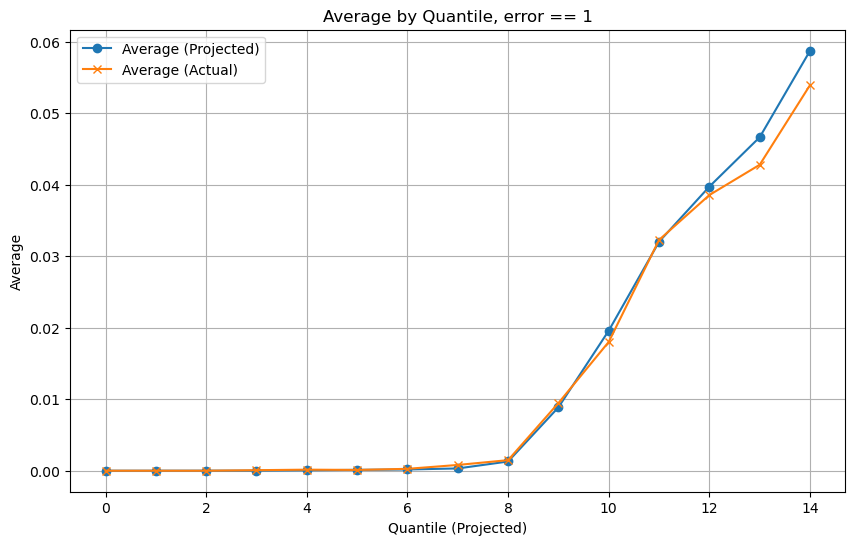

In [141]:
print(error_df[['error_1', 'error']].mean())

quantiles = 20

# Set Variable
var = "error"

# Copy 
graph_df = error_df.copy()

# Step 1: Divide error_1 into 
graph_df['quantile'] = pd.qcut(graph_df[f'{var}_1'], quantiles, labels=False, duplicates='drop')

# Step 2 & 3: Group by quantile and calculate average error_1 and error
grouped_quantiles = graph_df.groupby('quantile').agg({f'{var}_1': 'mean', f'{var}': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_quantiles['quantile'], grouped_quantiles[f'{var}_1'], marker='o', label='Average (Projected)')
plt.plot(grouped_quantiles['quantile'], grouped_quantiles[f'{var}'], marker='x', label='Average (Actual)')
plt.xlabel('Quantile (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Quantile, {var} == 1')
plt.legend()
plt.grid(True)
plt.show()


### Model B. Double Play

##### Inputs

In [142]:
double_play_input_list = list(event_dummies.columns) + ['outs_pre', 'pre_1b', 'pre_2b', 'pre_3b']

##### Sample

Universe: Typical events. Typical base movement. Using the batter as the observation.

In [143]:
X = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('minBase == 0')[double_play_input_list] 
y = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('minBase == 0')['double_play']

##### Train/Test Split

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

##### Settings

In [145]:
random_state = 10

##### Train

In [146]:
%%time
models = [
    MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', max_iter=10, random_state=random_state),
    # MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', max_iter=10, random_state=random_state+1),
    # MLPClassifier(hidden_layer_sizes=(50,50), activation='relu', max_iter=10, random_state=random_state+2)
    ]

# Create the ensemble classifier using VotingClassifier
predict_dp = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Create directory
os.makedirs(os.path.join(model_path, "M06. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_dp, open(os.path.join(model_path, "M06. Base Running", todaysdate, "predict_dp.sav"), 'wb'))

CPU times: total: 312 ms
Wall time: 1min 58s


##### Predict

In [147]:
# Get probability predictions on the test set
probabilities = predict_dp.predict_proba(X_test)

# Create DataFrame from probabilities
class_labels = predict_dp.classes_
probability_columns = [f'double_play_{label}' for label in class_labels]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
dp_df = pd.concat([X_test, y_test, probability_df], axis=1)

##### Evaluate

double_play_1   0.0216
double_play     0.0220
dtype: float64


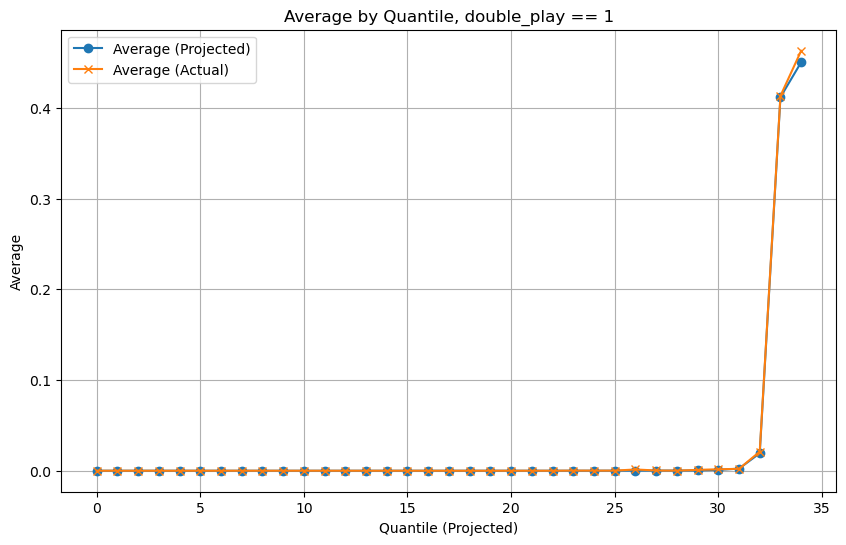

In [148]:
print(dp_df[['double_play_1', 'double_play']].mean())

# Set Variable
var = "double_play"

# Copy 
graph_df = dp_df.copy()

# Step 1: Divide error_1 into quantiles
graph_df['quantile'] = pd.qcut(graph_df[f'{var}_1'], 40, labels=False, duplicates='drop')

# Step 2 & 3: Group by quantile and calculate average double_play_1 and double_play
grouped_quantiles = graph_df.groupby('quantile').agg({f'{var}_1': 'mean', f'{var}': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_quantiles['quantile'], grouped_quantiles[f'{var}_1'], marker='o', label='Average (Projected)')
plt.plot(grouped_quantiles['quantile'], grouped_quantiles[f'{var}'], marker='x', label='Average (Actual)')
plt.xlabel('Quantile (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Quantile, {var} == 1')
plt.legend()
plt.grid(True)
plt.show()

### Model C. Out Bases

##### Inputs

In [149]:
out_input_list = list(event_dummies.columns) + list(minBase_dummies.columns) + ['outs_pre', 'pre_1b', 'pre_2b', 'pre_3b', 'error', 'double_play']

##### Sample

Universe: Typical events. Typical base movement. Batter and base runners as observations.

In [150]:
X = df.query('eventsModel != "Cut"').query('movementTypical == 1')[out_input_list] 
y = df.query('eventsModel != "Cut"').query('movementTypical == 1')['out']

##### Train/Test Split

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

##### Settings

In [152]:
random_state = 10

##### Train

In [153]:
%%time
# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=(50,50,), activation='relu', max_iter=10, random_state=random_state+1),
    MLPClassifier(hidden_layer_sizes=(50,50,), activation='relu', max_iter=10, random_state=random_state+2),
    MLPClassifier(hidden_layer_sizes=(50,50,), activation='relu', max_iter=10, random_state=random_state+3)
    ]

# Create the ensemble classifier using VotingClassifier
predict_out_bases = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Create directory
os.makedirs(os.path.join(model_path, "M06. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_out_bases, open(os.path.join(model_path, "M06. Base Running", todaysdate, "predict_out_bases.sav"), 'wb'))

CPU times: total: 703 ms
Wall time: 3min 4s


##### Predict

In [154]:
# Get probability predictions on the test set
probabilities = predict_out_bases.predict_proba(X_test)

# Create DataFrame from probabilities
probability_columns = [f'out_{label}' for label in predict_out_bases.classes_]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
outs_df = pd.concat([X_test, y_test, probability_df], axis=1)

##### Evaluate

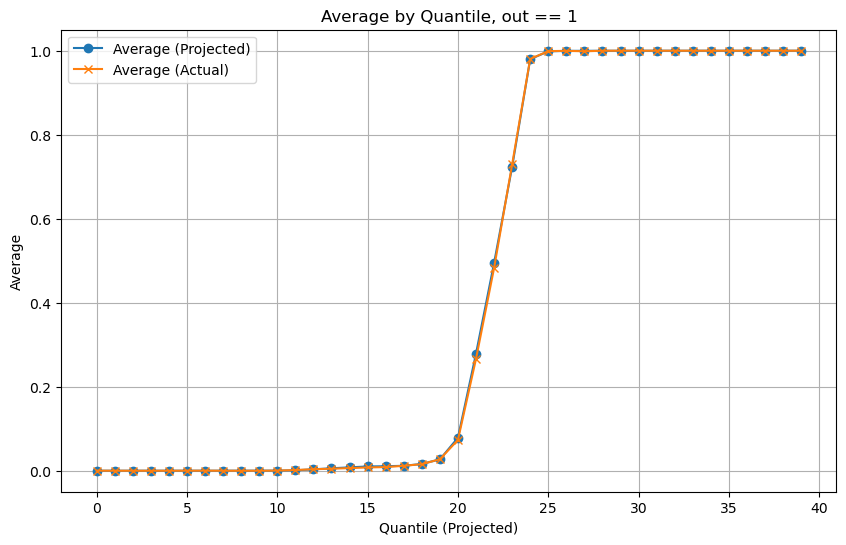

In [155]:
# Set Variable
var = "out"

# Copy 
graph_df = outs_df.copy()

# Step 1: Divide error_1 into quantiles
graph_df['quantile'] = pd.qcut(graph_df[f'{var}_1'], 40, labels=False, duplicates='drop')

# Step 2 & 3: Group by quantile and calculate average out_1 and out
grouped_quantiles = graph_df.groupby('quantile').agg({f'{var}_1': 'mean', f'{var}': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_quantiles['quantile'], grouped_quantiles[f'{var}_1'], marker='o', label='Average (Projected)')
plt.plot(grouped_quantiles['quantile'], grouped_quantiles[f'{var}'], marker='x', label='Average (Actual)')
plt.xlabel('Quantile (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Quantile, {var} == 1')
plt.legend()
plt.grid(True)
plt.show()


In [156]:
outs_df.query('(event_b1 == 1 or event_b2 == 1 or event_b3 == 1 or event_bb == 1 or event_hbp == 1)')[['out', 'out_1']].mean()

out     0.0071
out_1   0.0078
dtype: float64

In [157]:
outs_df.query('minBase_0 == 1')[['out', 'out_1']].mean()

out     0.6528
out_1   0.6531
dtype: float64

In [158]:
outs_df[['out', 'out_1']].mean()

out     0.4392
out_1   0.4399
dtype: float64

### Model D. Advances

##### Inputs

In [159]:
event_input_list = (list(event_dummies.columns) + list(minBase_dummies.columns) + 
                    ['outs_pre', 'pre_1b', 'pre_2b', 'pre_3b', 'blocked_1b', 'blocked_2b', 'blocked_3b', 'out_home', 'out_1b', 'out_2b', 'out_3b', 'error', 'double_play'])

In [160]:
df.query('eventsModel != "Cut"').query('movementTypical == 1').query('out == 0').query('event_b1 == 1').query('minBase_0 == 1')[event_input_list].head(10)

,event_b1,event_b2,event_b3,event_bb,event_fo,event_go,event_hbp,event_hr,event_lo,event_po,event_so,minBase_0,minBase_1,minBase_2,minBase_3,outs_pre,pre_1b,pre_2b,pre_3b,blocked_1b,blocked_2b,blocked_3b,out_home,out_1b,out_2b,out_3b,error,double_play
1097,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,0,2.0000,0,0,1,0,0,0,0,0,0,0,0,0
1085,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,0,0.0000,0,0,0,0,0,0,0,0,0,0,0,0
1050,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,0,0.0000,0,0,0,0,0,0,0,0,0,0,0,0
1012,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,0,1.0000,0,0,0,0,0,0,0,0,0,0,0,0
1005,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,0,1.0000,0,0,0,0,0,0,0,0,0,0,0,0
1004,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,0,1.0000,1,0,0,0,0,0,0,1,0,0,0,0
1046,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,0,1.0000,0,0,0,0,0,0,0,0,0,0,0,0
1045,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,0,1.0000,1,0,0,0,1,0,0,0,0,0,0,0
1028,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,0,1.0000,0,0,0,0,0,0,0,0,0,0,0,0
1027,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1,0,0,0,1.0000,1,0,0,0,0,0,0,0,0,0,0,0


##### Sample

Universe: Typical events. Typical base movement. Batter and base runners as observations. Player was not out.

In [161]:
X = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('out == 0')[event_input_list] 
y = df.query('eventsModel != "Cut"').query('movementTypical == 1').query('out == 0')['maxBase']

##### Train/Test Split

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

##### Settings

In [163]:
random_state = 1000

##### Train

In [164]:
df[event_input_list + ['post_1b', 'post_2b', 'post_3b']].describe()

,event_b1,event_b2,event_b3,event_bb,event_fo,event_go,event_hbp,event_hr,event_lo,event_po,event_so,minBase_0,minBase_1,minBase_2,minBase_3,outs_pre,pre_1b,pre_2b,pre_3b,blocked_1b,blocked_2b,blocked_3b,out_home,out_1b,out_2b,out_3b,error,double_play,post_1b,post_2b,post_3b
count,2733697.0000,2733697.0000,2733697.0000,2733697.0000,2733697.0000,2733697.0000,2733697.0000,2733697.0000,2733697.0000,2733697.0000,2733697.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000,2739384.0000
mean,0.1442,0.0444,0.0043,0.0862,0.1233,0.2350,0.0110,0.0308,0.0553,0.0470,0.2184,0.6239,0.2047,0.1126,0.0588,1.0615,0.5011,0.3093,0.1773,0.0000,0.0596,0.0605,0.6354,0.0644,0.0070,0.0041,0.0148,0.0362,0.3772,0.2565,0.1576
std,0.3513,0.2061,0.0651,0.2806,0.3288,0.4240,0.1042,0.1727,0.2286,0.2117,0.4131,0.4844,0.4035,0.3161,0.2352,0.8086,0.5000,0.4622,0.3820,0.0000,0.2368,0.2385,0.4813,0.2455,0.0835,0.0642,0.1208,0.1867,0.4847,0.4367,0.3644
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,2.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [165]:
%%time
# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=100, random_state=random_state+1),
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=100, random_state=random_state+2),
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=100, random_state=random_state+3),
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=100, random_state=random_state+4),
    MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=100, random_state=random_state+5)
    ]

# Create the ensemble classifier using VotingClassifier
predict_events = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train, y_train)

# Create directory
os.makedirs(os.path.join(model_path, "M06. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_events, open(os.path.join(model_path, "M06. Base Running", todaysdate, "predict_events.sav"), 'wb'))

CPU times: total: 656 ms
Wall time: 2min 12s


##### Predict

In [166]:
# Get probability predictions on the test set
probabilities = predict_events.predict_proba(X_test)

# Create DataFrame from probabilities
probability_columns = [f'base_{label}' for label in predict_events.classes_]
probability_df = pd.DataFrame(probabilities, columns=probability_columns, index=X_test.index)

# Concatenate probability_df with y_test and X_test
events_df = pd.concat([X_test, y_test, probability_df], axis=1)

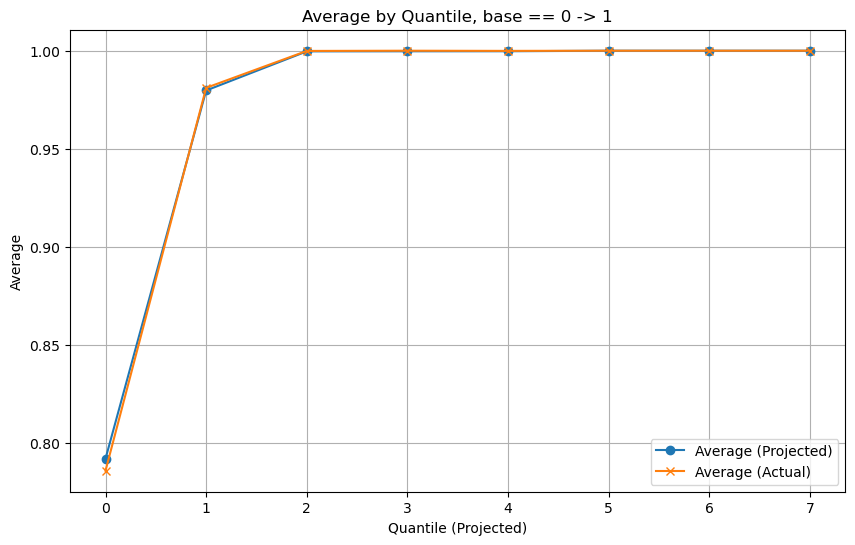

In [167]:
# Set Variables
var = "base"
origin_base = 0
destination_base = 1
event = "b1"
# This one is a little confusing, but it basically shows the probability of ending up at a given base by event type.

# Copy 
graph_df = events_df.copy()
graph_df = events_df.query(f'event_{event} == 1 and minBase_{origin_base} == 1')
graph_df['base_dummy'] = (graph_df['maxBase'] == destination_base).astype('int')

# Step 1: Divide variable into quantile
graph_df['quantile'] = pd.qcut(graph_df[f'{var}_{destination_base}'], 10, labels=False, duplicates='drop')

# Step 2 & 3: Group by quantiles and calculate predicted and actual destination base rates
grouped_quantiles = graph_df.groupby('quantile').agg({f'{var}_{destination_base}': 'mean', 'base_dummy': 'mean'}).reset_index()

# Step 4: Plot the averages
plt.figure(figsize=(10, 6))
plt.plot(grouped_quantiles['quantile'], grouped_quantiles[f'{var}_{destination_base}'], marker='o', label='Average (Projected)')
plt.plot(grouped_quantiles['quantile'], grouped_quantiles[f'base_dummy'], marker='x', label='Average (Actual)')
plt.xlabel('Quantile (Projected)')
plt.ylabel('Average')
plt.title(f'Average by Quantile, {var} == {origin_base} -> {destination_base}')
plt.legend()
plt.grid(True)
plt.show()

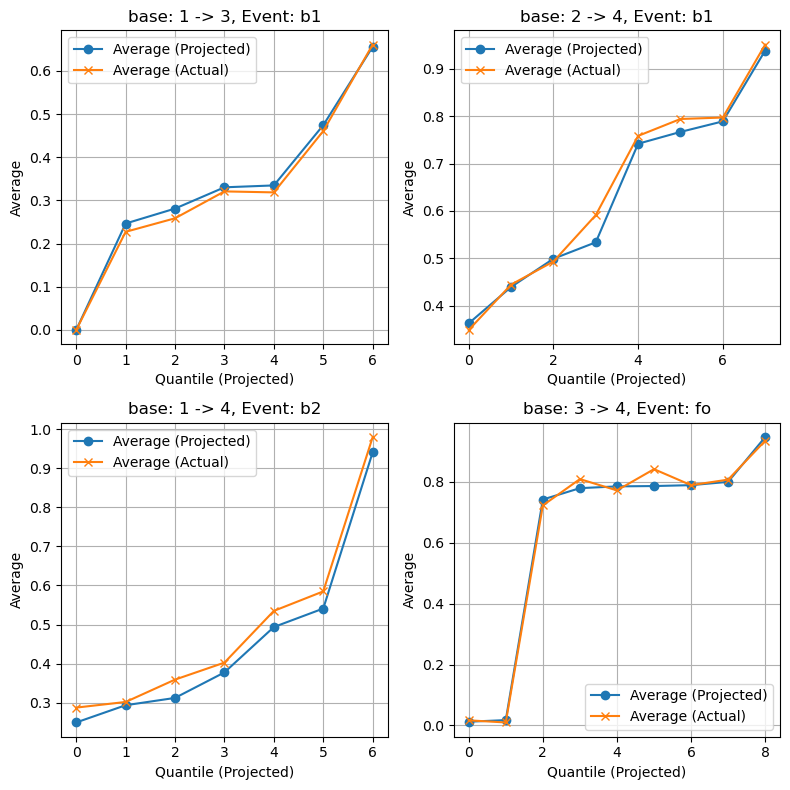

In [168]:
# Define configurations for the 2x2 grid
configs = [
    {"origin_base": 1, "destination_base": 3, "event": "b1"},
    {"origin_base": 2, "destination_base": 4, "event": "b1"},
    {"origin_base": 1, "destination_base": 4, "event": "b2"},
    {"origin_base": 3, "destination_base": 4, "event": "fo"},
]

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

# Iterate through configurations and axes
for i, config in enumerate(configs):
    origin_base = config["origin_base"]
    destination_base = config["destination_base"]
    event = config["event"]
    var = "base"

    # Copy and filter data
    graph_df = events_df.query(f'event_{event} == 1 and minBase_{origin_base} == 1')
    graph_df['base_dummy'] = (graph_df['maxBase'] == destination_base).astype('int')

    # Divide destination base into quantiles
    graph_df['quantile'] = pd.qcut(graph_df[f'{var}_{destination_base}'], 10, labels=False, duplicates='drop')

    # Group by quantile and calculate averages
    grouped_quantiles = graph_df.groupby('quantile').agg({
        f'{var}_{destination_base}': 'mean', 
        'base_dummy': 'mean'
    }).reset_index()

    # Plot on the respective subplot
    ax = axes[i]
    ax.plot(grouped_quantiles['quantile'], grouped_quantiles[f'{var}_{destination_base}'], marker='o', label='Average (Projected)')
    ax.plot(grouped_quantiles['quantile'], grouped_quantiles[f'base_dummy'], marker='x', label='Average (Actual)')
    ax.set_title(f'{var}: {origin_base} -> {destination_base}, Event: {event}')
    ax.set_xlabel('Quantile (Projected)')
    ax.set_ylabel('Average')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [169]:
events_df['to_1b'] = (events_df['maxBase'] == 1).astype(int)
events_df['to_2b'] = (events_df['maxBase'] == 2).astype(int)
events_df['to_3b'] = (events_df['maxBase'] == 3).astype(int)
events_df['to_home'] = (events_df['maxBase'] == 4).astype(int)

In [170]:
print(f"2B -> H on a Single: {events_df.query('event_b1 == 1 and minBase_2 == 1')['base_4'].mean()}, {events_df.query('event_b1 == 1 and minBase_2 == 1')['to_home'].mean()}")
print(f"1B -> H on a Double: {events_df.query('event_b2 == 1 and minBase_1 == 1')['base_4'].mean()}, {events_df.query('event_b2 == 1 and minBase_1 == 1')['to_home'].mean()}")
print(f"1B -> 3B on a Single: {events_df.query('event_b1 == 1 and minBase_1 == 1')['base_3'].mean()}, {events_df.query('event_b1 == 1 and minBase_1 == 1')['to_3b'].mean()}")
print(f"3B -> H on a FO: {events_df.query('event_fo == 1 and minBase_3 == 1 and outs_pre < 2')['base_4'].mean()}, {events_df.query('event_fo == 1 and minBase_3 == 1 and outs_pre < 2')['to_home'].mean()}")

2B -> H on a Single: 0.6125445996337981, 0.62636048319579
1B -> H on a Double: 0.3934833124995634, 0.42740243390684013
1B -> 3B on a Single: 0.3025537288458151, 0.28766511390466465
3B -> H on a FO: 0.7904921354350671, 0.8093607305936074


### Model E. Attempt to Steal 2B

##### Inputs

In [ ]:
input_list = ['outs_pre', 'sba_imp', 'sb_imp']

##### Settings

In [ ]:
cutoff = 30
year = 2023

##### Sample

Universe: Runner on first. No runner on second. Runner on first is observation. Runner has 30 stolen base opportunities (instances of being on first base).

In [ ]:
X = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_1b == 1 and pre_2b == 0 and minBase == 1').query(f'year >= {year}')[input_list]
y = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_1b == 1 and pre_2b == 0 and minBase == 1').query(f'year >= {year}')['sba_2b']

##### Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

##### Train

In [ ]:
%%time
# Create and train the MLPClassifier
predict_sba_2b = MLPClassifier(hidden_layer_sizes=(4,4,4), activation='relu', early_stopping=False, max_iter=100, random_state=1200000)
predict_sba_2b.fit(X_train, y_train)

# Create directory
os.makedirs(os.path.join(model_path, "M06. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_sba_2b, open(os.path.join(model_path, "M06. Base Running", todaysdate, "predict_sba_2b.sav"), 'wb'))

##### Predict

In [ ]:
# Get probability predictions on the test set
probabilities = predict_sba_2b.predict_proba(X_test)

# Create DataFrame from probabilities
probability_df = pd.DataFrame(probabilities, columns=['sba_2b_not', 'sba_2b_pred'], index=X_test.index)

# Concatenate probability_df with y_test and X_test
sba_2b_df = pd.concat([X_test, y_test, probability_df], axis=1)

##### Evaluate

In [ ]:
quantiles = 10

# Add quantiles (to examine how well predictions match actual results)
sba_2b_df['quantile'] = pd.qcut(sba_2b_df['sba_2b_pred'], quantiles, labels=False)
globals()["sba_2b_df_quantiles"] = sba_2b_df.groupby('quantile')[['sba_2b', 'sba_2b_pred']].mean().reset_index()

In [ ]:
print(sba_2b_df[['sba_2b_pred', 'sba_2b']].mean())

# Create figures
plt.plot(sba_2b_df_quantiles['quantile'], sba_2b_df_quantiles['sba_2b_pred'], color='red')
plt.plot(sba_2b_df_quantiles['quantile'], sba_2b_df_quantiles['sba_2b'], color='black')
plt.show() 

### Model F. Attempt to Steal 3B

##### Inputs

In [ ]:
input_list = ['outs_pre', 'sba_imp', 'sb_imp']

##### Settings

In [ ]:
cutoff = 30
year = 2023

##### Sample

In [ ]:
X = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_2b == 1 and pre_3b == 0 and minBase == 2').query(f'year >= {year}')[input_list]
y = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_2b == 1 and pre_3b == 0 and minBase == 2').query(f'year >= {year}')['sba_3b']

##### Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Train

In [ ]:
%%time
# Create and train the MLPClassifier
predict_sba_3b = MLPClassifier(hidden_layer_sizes=(40,40), activation='relu', early_stopping=False, max_iter=100, random_state=21000)
predict_sba_3b.fit(X_train, y_train)

# Create directory
os.makedirs(os.path.join(model_path, "M06. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_sba_3b, open(os.path.join(model_path, "M06. Base Running", todaysdate, "predict_sba_3b.sav"), 'wb'))

##### Predict

In [ ]:
# Get probability predictions on the test set
probabilities = predict_sba_3b.predict_proba(X_test)

# Create DataFrame from probabilities
probability_df = pd.DataFrame(probabilities, columns=['sba_3b_not', 'sba_3b_pred'], index=X_test.index)

# Concatenate probability_df with y_test and X_test
sba_3b_df = pd.concat([X_test, y_test, probability_df], axis=1)

##### Evaluate

In [ ]:
quantiles = 10 

# Add quantiles (to examine how well predictions match actual results)
sba_3b_df['quantile'] = pd.qcut(sba_3b_df['sba_3b_pred'], quantiles, labels=False)
globals()["sba_3b_df_quantiles"] = sba_3b_df.groupby('quantile')[['sba_3b', 'sba_3b_pred']].mean().reset_index()

In [ ]:
print(sba_3b_df[['sba_3b_pred', 'sba_3b']].mean())

# Create figures
plt.plot(sba_3b_df_quantiles['quantile'], sba_3b_df_quantiles['sba_3b_pred'], color='red')
plt.plot(sba_3b_df_quantiles['quantile'], sba_3b_df_quantiles['sba_3b'], color='black')
plt.show() 

### Model G. Steal 2B

##### Inputs

In [ ]:
input_list = ['outs_pre', 'sba_imp', 'sb_imp']

##### Settings

In [ ]:
cutoff = 30
year = 2023

##### Sample

In [ ]:
X = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_1b == 1 and pre_2b == 0 and sba_2b == 1 and minBase == 1').query(f'year >= {year}')[input_list]
y = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_1b == 1 and pre_2b == 0 and sba_2b == 1 and minBase == 1').query(f'year >= {year}')['sb_2b']

##### Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

##### Train

In [ ]:
%%time
# Create and train the MLPClassifier
predict_sb_2b = MLPClassifier(hidden_layer_sizes=(128,64), activation='relu', max_iter=100, random_state=2000)
predict_sb_2b.fit(X_train, y_train)

# Create directory
os.makedirs(os.path.join(model_path, "M06. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_sb_2b, open(os.path.join(model_path, "M06. Base Running", todaysdate, "predict_sb_2b.sav"), 'wb'))

##### Predict

In [ ]:
# Get probability predictions on the test set
probabilities = predict_sb_2b.predict_proba(X_test)

# Create DataFrame from probabilities
probability_df = pd.DataFrame(probabilities, columns=['sb_2b_not', 'sb_2b_pred'], index=X_test.index)

# Concatenate probability_df with y_test and X_test
sb_2b_df = pd.concat([X_test, y_test, probability_df], axis=1)

##### Evaluate

In [ ]:
quantiles = 10

# Add xtiles (to examine how well predictions match actual results)
sb_2b_df['quantile'] = pd.qcut(sb_2b_df['sb_2b_pred'], quantiles, labels=False)
globals()["sb_2b_df"] = sb_2b_df.groupby('quantile')[['sb_2b', 'sb_2b_pred']].mean().reset_index()

In [ ]:
print(sb_2b_df[['sb_2b_pred', 'sb_2b']].mean())

# Create figures
plt.plot(sb_2b_df['quantile'], sb_2b_df['sb_2b_pred'], color='red')
plt.plot(sb_2b_df['quantile'], sb_2b_df['sb_2b'], color='black')
plt.show() 

### Model H. Steal 3B

##### Inputs

In [ ]:
input_list = ['outs_pre', 'sba_imp', 'sb_imp']

##### Settings

In [ ]:
cutoff = 30
year = 2023

##### Sample

In [ ]:
X = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_2b == 1 and pre_3b == 0 and sba_3b == 1 and minBase == 2').query(f'year >= {year}')[input_list]
y = df.dropna(subset=input_list).query(f'sbo > {cutoff}').query('pre_2b == 1 and pre_3b == 0 and sba_3b == 1 and minBase == 2').query(f'year >= {year}')['sb_3b']

##### Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000000)

##### Train

In [ ]:
%%time
# Create and train the MLPClassifier
predict_sb_3b = MLPClassifier(hidden_layer_sizes=(8,4), activation='relu', max_iter=100, random_state=random.randint(0,9999))
predict_sb_3b.fit(X_train, y_train)

# Create directory
os.makedirs(os.path.join(model_path, "M06. Base Running", todaysdate), exist_ok=True)

# Save model
pickle.dump(predict_sb_3b, open(os.path.join(model_path, "M06. Base Running", todaysdate, "predict_sb_3b.sav"), 'wb'))

##### Predict

In [ ]:
# Get probability predictions on the test set
probabilities = predict_sb_3b.predict_proba(X_test)

# Create DataFrame from probabilities
probability_df = pd.DataFrame(probabilities, columns=['sb_3b_not', 'sb_3b_pred'], index=X_test.index)

# Concatenate probability_df with y_test and X_test
sb_3b_df = pd.concat([X_test, y_test, probability_df], axis=1)

##### Evaluate

In [ ]:
quantiles = 5

# Add xtiles (to examine how well predictions match actual results)
sb_3b_df['quantile'] = pd.qcut(sb_3b_df['sb_3b_pred'], quantiles, labels=False)
globals()["sb_3b_df"] = sb_3b_df.groupby('quantile')[['sb_3b', 'sb_3b_pred']].mean().reset_index()

In [ ]:
print(sb_3b_df[['sb_3b_pred', 'sb_3b']].mean())

# Create figures
plt.plot(sb_3b_df['quantile'], sb_3b_df['sb_3b_pred'], color='red')
plt.plot(sb_3b_df['quantile'], sb_3b_df['sb_3b'], color='black')
plt.show()

Note: Stolen base models are restricted to 2023 and later to account for changes to base sizes and pick off rules. This reduces sample size, but should result in more realistic average rates.